In [1]:
import numpy as np                     # Llibreria matemÃ tica
import matplotlib.pyplot as plt        # Per mostrar plots
import sklearn                         # Llibreia de DM
import sklearn.datasets as ds            # Per carregar mÃ©s facilment el dataset digits
import sklearn.model_selection as cv    # Pel Cross-validation
import sklearn.neighbors as nb           # Per fer servir el knn
from sklearn.model_selection import cross_val_score  
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [2]:
data = pd.read_csv('games_clean.csv')

In [3]:
column = data.columns.get_loc('Metacritic')
y = data.iloc[:,column]
X = data.loc[:, data.columns != 'Metacritic']


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)
y_train
cv_value= 6

## Normalization
Data should be numerical and normalized or standarized before using an SVM.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
# Apply the normalization trained in training data in both training and test sets
X_train = scaler.transform(X_train)
scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_test)

X_test = scaler.transform(X_test)


## Linear SVM

Let's try an SVM with default parameters. Linear means that we are not using any kernel to move the data to a higher dimensional space.

In [6]:
knc = SVC(kernel='linear')
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("Confusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))


Confusion matrix on test set:
 [[71 32 40 35]
 [61 35 30 32]
 [54 35 26 33]
 [46 30 46 54]]

Accuracy on test set:  0.2818181818181818


In [7]:
pd.Series(pred).value_counts()

(19.999, 65.464]    232
(73.684, 94.0]      154
(69.955, 73.684]    142
(65.464, 69.955]    132
dtype: int64

Not bad results. However, the linear SVM has parameter C that has to be adjusted. We will use *GridSearch* method to find the optimal value of C like we did in a previous notebook with the k value of the KNN algorithm.  

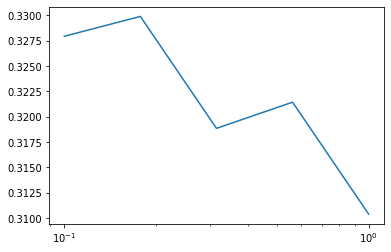

Acc.  6 -fold cross on train data=  0.3298779993514916

Confusion matrix on test set:
 [[71 34 33 40]
 [68 33 34 23]
 [49 35 34 30]
 [43 20 46 67]]

Accuracy on test set:  0.3106060606060606

Best value of parameter C found:  {'C': 0.17782793076729345}

Number of supports:  1443 ( 2354 of them have slacks)
Prop. of supports:  0.937012987012987


In [8]:
# List of C values to test. We usualy test diverse orders of magnitude
Cs = np.logspace(-1,-0.0000001, num=5, base=10.0)

param_grid = {'C': Cs}
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=cv_value, n_jobs=-1)
grid_search.fit(X_train,y_train)

# Let's plot the 10-fold cross.validation accuracy deppending on C
scores = grid_search.cv_results_['mean_test_score']
plt.semilogx(Cs,scores)
plt.show()

parval=grid_search.best_params_
cvacc = cross_val_score(SVC(C=parval['C'],kernel='linear'), X=X_train,  y=y_train, cv=cv_value, scoring='accuracy')
print('Acc. ',cv_value,'-fold cross on train data= ', cvacc.mean())


# Let's apply the best C parameter found to the test set

knc = SVC(C=parval['C'],kernel='linear')
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("\nConfusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))
print("\nBest value of parameter C found: ",parval)
print("\nNumber of supports: ",np.sum(knc.n_support_), "(",np.sum(np.abs(knc.dual_coef_)==parval['C']) ,"of them have slacks)")
print("Prop. of supports: ",np.sum(knc.n_support_)/X_train.shape[0])


How the C parameter affects performance on training and test sets. 

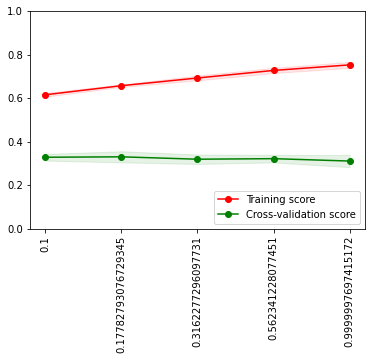

In [9]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(parameter_values, train_scores, validation_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc=4)

training_scores, test_scores = validation_curve(SVC(kernel='linear'), X_train, y_train, param_name="C", param_range=Cs,cv=cv_value)
plot_validation_curve(range(len(Cs)), training_scores, test_scores)
plt.xticks(range(len(Cs)), Cs,rotation='vertical');
plt.ylim([0, 1])
plt.show()

In [10]:
print(training_scores)
print(test_scores)

[[0.61184723 0.62821512 0.62587685 0.6141855  0.60514019 0.605919  ]
 [0.6578332  0.6578332  0.66718628 0.65627436 0.65498442 0.64797508]
 [0.69524552 0.7014809  0.70849571 0.69212783 0.67912773 0.67757009]
 [0.73031956 0.73967264 0.74201091 0.72876072 0.71183801 0.71028037]
 [0.75214341 0.76461419 0.77318784 0.75136399 0.74376947 0.73130841]]
[[0.3229572  0.3463035  0.3307393  0.307393   0.3125     0.34765625]
 [0.31906615 0.36964981 0.31906615 0.29961089 0.3125     0.359375  ]
 [0.30350195 0.35019455 0.3151751  0.28793774 0.3125     0.34375   ]
 [0.3229572  0.3540856  0.3151751  0.29961089 0.30859375 0.328125  ]
 [0.3463035  0.3229572  0.26848249 0.307393   0.28125    0.3359375 ]]


## Polynomial kernels

First we will train our model with different degrees 

In [11]:
l = []
l2 = []
for i in range(1, 15):    
    print("Results degree with", i, "degrees")
    cvacc = cross_val_score(SVC(kernel='poly',degree =i) , X=X_train,  y=y_train, cv=cv_value, scoring='accuracy')
    print('Acc. ',cv_value,'-fold cross on train data= ', cvacc.mean())
    l = l + [cvacc.mean()]
    knc = SVC(kernel='poly',degree =i) 
    knc.fit(X_train, y_train)
    pred=knc.predict(X_test,)
    l2 = l2 + [sklearn.metrics.accuracy_score(y_test, pred)]


Results degree with 1 degrees
Acc.  6 -fold cross on train data=  0.31362982328145267
Results degree with 2 degrees
Acc.  6 -fold cross on train data=  0.3214473897535668
Results degree with 3 degrees
Acc.  6 -fold cross on train data=  0.3149496392671855
Results degree with 4 degrees
Acc.  6 -fold cross on train data=  0.2980732206549935
Results degree with 5 degrees
Acc.  6 -fold cross on train data=  0.3045659046692607
Results degree with 6 degrees
Acc.  6 -fold cross on train data=  0.31367035505836577
Results degree with 7 degrees
Acc.  6 -fold cross on train data=  0.309771704766537
Results degree with 8 degrees
Acc.  6 -fold cross on train data=  0.31561334711413747
Results degree with 9 degrees
Acc.  6 -fold cross on train data=  0.3156057474059663
Results degree with 10 degrees
Acc.  6 -fold cross on train data=  0.3188533560311284
Results degree with 11 degrees
Acc.  6 -fold cross on train data=  0.31430619730868997
Results degree with 12 degrees
Acc.  6 -fold cross on train 

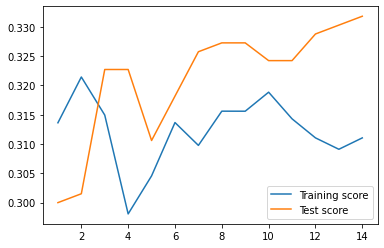

In [12]:
plt.plot(range(1,15),l, label="Training score")
plt.plot(range(1,15),l2, label="Test score")
plt.legend(loc=4)

Then we'll try first ploynomial kernel with degree 2 with default parameters.

In [13]:
knc = SVC(kernel='poly',degree =2) 
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("Confusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))


Confusion matrix on test set:
 [[69 37 35 37]
 [66 41 26 25]
 [53 30 32 33]
 [41 32 46 57]]

Accuracy on test set:  0.3015151515151515


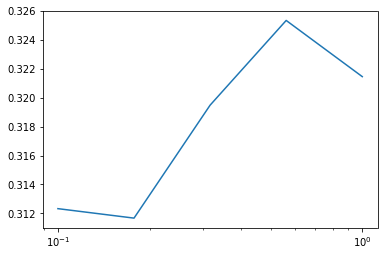

Acc.  6 -fold cross on train data=  0.3253283073929961

Confusion matrix on test set:
 [[65 37 35 41]
 [63 37 32 26]
 [49 35 35 29]
 [39 27 45 65]]

Accuracy on test set:  0.30606060606060603

Best combination of parameters found:  {'C': 0.562341228077451}

Number of supports:  1462 ( 2210 of them have slacks)
Prop. of supports:  0.9493506493506494


In [14]:
Cs = np.logspace(-1,-0.0000001, num=5, base=10.0)

param_grid = {'C': Cs}
grid_search = GridSearchCV(SVC(kernel='poly',degree =2) , param_grid, cv=cv_value, n_jobs=-1)
grid_search.fit(X_train,y_train)

scores = grid_search.cv_results_['mean_test_score']

plt.semilogx(Cs,scores)
plt.show()

parval=grid_search.best_params_

cvacc = cross_val_score(SVC(kernel='poly',degree =2,C=parval['C']) , X=X_train,  y=y_train, cv=cv_value, scoring='accuracy')
print('Acc. ',cv_value,'-fold cross on train data= ', cvacc.mean())


knc = SVC(kernel='poly',degree =2,C=parval['C']) 
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("\nConfusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))
print("\nBest combination of parameters found: ",parval)
print("\nNumber of supports: ",np.sum(knc.n_support_), "(",np.sum(np.abs(knc.dual_coef_)==parval['C']) ,"of them have slacks)")
print("Prop. of supports: ",np.sum(knc.n_support_)/X_train.shape[0])


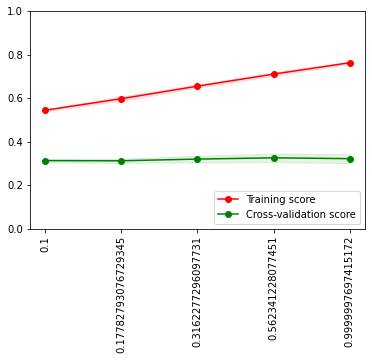

In [15]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(parameter_values, train_scores, validation_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc=4)

training_scores, test_scores = validation_curve(SVC(kernel='poly',degree =2,C=parval['C']) , X_train, y_train, param_name="C", param_range=Cs,cv=cv_value)
plot_validation_curve(range(len(Cs)), training_scores, test_scores)
plt.xticks(range(len(Cs)), Cs,rotation='vertical');
plt.ylim([0, 1])
plt.show()

## RBF Kernel
RBF with default parameters.

In [16]:
knc = SVC() 
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("Confusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sklearn.metrics.accuracy_score(y_test, pred))


Confusion matrix on test set:
 [[72 19 49 38]
 [64 25 35 34]
 [47 19 45 37]
 [40 24 41 71]]

Accuracy on test set:  0.32272727272727275


C parameter and the gamma parameter

In [ ]:
# Values we will test for each parameter. When observin results, consider the limits of the 
# values tested and increase them if necessary 
gammas = [0.000001,0.00001, 0.0001,0.001,0.01,0.1,1,10]
Cs = np.logspace(-3, 3, num=9, base=10.0)

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(), param_grid,  cv=cv_value, n_jobs=-1)
grid_search.fit(X_train,y_train)
parval=grid_search.best_params_

# We'll show in a grid, the accuracy for each combination of parameters tester
scores = grid_search.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.matshow(scores)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'],rotation='vertical')
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.show()
parval=grid_search.best_params_
print("\nBest combination of parameters found: ",parval)


cvacc = cross_val_score(SVC(C=parval['C'], gamma=parval['gamma']) , X=X_train,  y=y_train, cv=cv_value, scoring='accuracy')
knc = SVC(C=parval['C'], gamma=parval['gamma']) 
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
print("Confusion matrix on test set:\n",sklearn.metrics.confusion_matrix(y_test, pred))
print('\nAcc. ',cv_value,'-fold cross on train data= ', cvacc.mean())
